# Prepare VCF File from a HDF5 file / RUN PLINK on it
goal: Have pipeline that prepares VCF file and then can run PLINK on it and produce output in a PLINK folder within HAPSBURGs output system

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


## Define Functions needed for conversion

In [17]:
def load_h5(path, output=True):
    """Load HDF5 from path and return hdf5 object"""
    f = h5py.File(path, "r") # Load for Sanity Check. See below!

    if output == True:
        print("Loaded HDF5")
        print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
        print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
        print(list(f["calldata"].keys()))
        print(list(f["variants"].keys()))
        #self.f["samples"] # Samples Vector

    ### Sanity Check whether both Genotypes are there and nothing else
    assert(np.min(f["calldata/GT"]) == 0)
    assert(np.max(f["calldata/GT"]) == 1)
    
    return f

def add_gt_data(df, gt, ad=[], iids=[], m_sym="."):
    """Add Genotype and Allele Depth Fields [l,n,2] for iids to pandas dataframe df.
    Return modified Data Frame"""
    assert(np.shape(gt)[1]==len(iids)) # Sanity Check
    
    ### Replace missing Data with dot again
    missing = gt<0  # Missing Data
    gt = gt.astype("str") ## Convert To String
    gt[missing] = m_sym
    
    gt_vcf = np.core.defchararray.add(gt[:,:,0], "/")
    gt_vcf = np.core.defchararray.add(gt_vcf, gt[:,:,1])
        
    for i, iid in enumerate(iids):
        #data = map('/'.join, zip(gt[:,i,0], gt[:,i,1]))
        df[iid] = gt_vcf[:,i]
        
        #if len(ad)>0:   # Add Allele Depth Data if needed
        #    print("Implement this") 
    return df

def to_vcf(chrom, pos, ref, alt, gt, iids, vcf_path, header=[]):
    """"""
    ### Hard-Coded Default Header
    if len(header)==0:
        header = """##fileformat=VCFv4.3\n##FILTER=<ID=PASS,Description="All filters passed">\n##fileDate=20191010\n##source=1000GenomesPhase3Pipeline\n##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz\n"""     
        
    #last_line_h =  "\n#CHROM POS ID REF ALT QUAL FILTER INFO"
    dct = {'#CHROM':chrom, 'POS':pos, 'REF':ref, 'ALT':alt}
    df = pd.DataFrame(dct)
    df['ID'] = ""
    df['QUAL'] = 40
    df['FILTER'] = ""
    df['INFO'] = ""
    df["FORMAT"] = "GT"  # GT:AD if allele depth given

    df = df[['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', "FORMAT"]] 

    ### Add the Genotype Data
    add_gt_data(df, gt, iids=iids)
    
    ### Write the Header
    with open(vcf_path, 'w') as vcf:
        vcf.write(header)
        #vcf.write(last_line_h)

    #### Write the tab seperated data
    df.to_csv(vcf_path, sep="\t", mode='a', index=False)  # Append
    print(f"Successfully saved VCF to {vcf_path}")
    
def hdf5_to_vcf(path_h5, path_vcf, iids=[], markers=[], chrom=0):
    """Load HDF5 from path_h5, extract iids and
    (if given) markers by position and save vcf to path_vcf.
    iids: Which Individuals to match and save. If none give: Save all!"""
    
    f = load_h5(path=path_h5)
    
    if len(iids)==0:
        iids = f["samples"][:]
        
    if chrom==0:
        chrom = f["variants/CHROM"][:]
        
    pos = f["variants/POS"][:]
    ref = f["variants/REF"][:] 
    alt = f["variants/ALT"][:] 
    
    idx = np.isin(f["samples"], iids)
    gt = f["calldata/GT"][:,idx,:]

    to_vcf(chrom, pos, ref, alt, gt, iids, path_vcf)

### Test with Example Data

In [18]:
### Before copying to the above 
iids= ["HG00097", 'HG00099']
f = load_h5(path="./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5")
idx = np.isin(f["samples"], iids)

chrom = [20, 20, 20, 20, 20] 
pos = [14370, 17330, 1110696, 1230237, 1234567] 
ref = ['G', 'T', 'A', 'T', 'T'] 
alt = ['A', 'A', 'G', 'C', 'G']

# For testing purposes
gt = f["calldata/GT"][:5,:3,:]
iids = f["samples"][:3]

vcf_path = "./Diverse/test.vcf"
to_vcf(chrom, pos, ref, alt, gt, iids, vcf_path)

Loaded HDF5
Loaded 77652 variants
Loaded 503 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']
Successfully saved VCF to ./Diverse/test.vcf


# Convert a whole HDF5 File to VCF

In [120]:
%%time
#path_h5 = "./Simulated/1000G_Mosaic/TSI/ch3_5cm/data.h5"
path_h5 = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/data.h5"
path_vcf = "./Diverse/TSI4cmIID0.vcf"
iids = ["iid0",]
hdf5_to_vcf(path_h5, path_vcf, iids=iids, markers=[], chrom=3)

Loaded HDF5
Loaded 77652 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']
Successfully saved VCF to ./Diverse/TSI4cmIID0.vcf
CPU times: user 598 ms, sys: 68.1 ms, total: 666 ms
Wall time: 680 ms


# Run PLINK

In [122]:
file = path_vcf
input_folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/"
output_folder = os.path.join(input_folder, "plink/roh")

!plink --homozyg --vcf $file --homozyg-window-snp 50 --homozyg-kb 500 --homozyg-window-het 1 --homozyg-window-threshold 0.05 --homozyg-gap 1000 --homozyg-density 50 --out $output_folder

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/plink/roh.log.
Options in effect:
  --homozyg
  --homozyg-density 50
  --homozyg-gap 1000
  --homozyg-kb 500
  --homozyg-window-het 1
  --homozyg-window-snp 50
  --homozyg-window-threshold 0.05
  --out ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/plink/roh
  --vcf ./Diverse/TSI4cmIID0.vcf

7704 MB RAM detected; reserving 3852 MB for main workspace.
--vcf:
./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/plink/roh-temporary.bed
+
./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/plink/roh-temporary.bim
+
./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/plink/roh-temporary.fam
written.
77652 variants loaded from .bim file.
1 person (0 males, 0 females, 1 ambiguous) loaded from .fam.
Ambiguous sex ID written to
./Simulated/1000G_Mosaic/TSI5/c

# Plot PLINK

In [123]:
df_plink = pd.read_csv(output_folder + ".hom", sep=r"\s+", engine="python")
#df_map = pd.read_csv(input_folder + "map.csv", header=None)

### Create the Mapping Dictionary
f = load_h5(path=path_h5)
new_dict = dict(zip(f["variants/POS"], f["variants/MAP"]))

### Create Begin and End Point in Morgan ###Takes about 10s
df_plink["POS1m"] = df_plink["POS1"].map(new_dict)
df_plink["POS2m"] = df_plink["POS2"].map(new_dict)

Loaded HDF5
Loaded 77652 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']


In [124]:
input_folder  = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/test_d/"
#input_folder = "./Simulated/1000G_Mosaic/TSI/ch3_5cm/output/iid0/chr3/"
ob_stat = np.loadtxt(input_folder + "hap.csv", dtype="int", delimiter=",")
het = (ob_stat[0,:] != ob_stat[1,:])

gmap = np.loadtxt(input_folder + "map.csv", dtype="float", delimiter=",")
df_roh  = pd.read_csv(input_folder + "roh.csv", delimiter=",")

### Plot HAPSBURG ROH vrs PLINK ROH

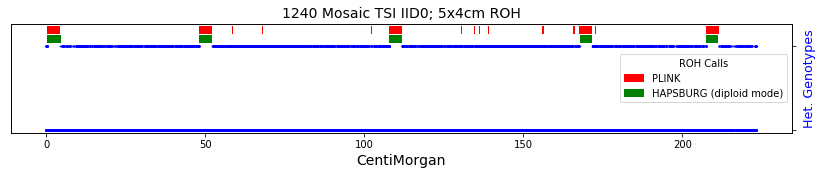

In [147]:
fs = 14
lw = 8 # The Line With of the Inferred ROH Calls
het_c="blue"
post_c="maroon"
cm_lim = []
#cm_lim=[150,170]

plt.figure(figsize=(14,2))
ax1=plt.gca()

ax1.hlines(y=[1.25]*len(df_plink), xmin=100 * df_plink["POS1m"], xmax= 100*df_plink["POS2m"], 
                colors="red", linewidth=lw, label="PLINK")

plt.hlines(y=[1.14]*len(df_roh), xmin=100 * df_roh["StartM"], xmax= 100 * df_roh["EndM"], 
                        colors="green", linewidth=lw, label="HAPSBURG (diploid mode)")

ax1.set_ylim([-0.09,1.33])
ax1.plot(gmap*100, (het * 1.1 - 0.05), "o", ms=1, alpha=0.3, zorder=0, color=het_c)
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax1.set_yticks([])
ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
ax2.set_yticklabels([])
ax1.set_yticklabels([])
ax2.set_ylabel(f"Het. Genotypes", fontsize=fs*0.9, color=het_c)

#ax1.set_ylabel("Post. Probability", fontsize=fs, color=post_c)
ax1.set_xlabel("SNP", fontsize=fs)
ax1.set_xlabel("CentiMorgan")

ax1.legend(loc = "center right", title="ROH Calls")

if len(cm_lim)>0:
    ax1.set_xlim(cm_lim)
    
ax1.set_title("1240 Mosaic TSI IID0; 5x4cm ROH", fontsize=fs)
plt.show()

In [ ]:
def plot_posterior_cm(folder = "../Simulated/Test20r/", savepath="", empirical=True, 
                      plot=True, cm_lim=[], m=1, groundtruth=False, readcount=False, 
                     plot_hets=True, plot_calls=True, plot_post=True,
                      figsize=(14,4), title="", post_c="maroon", het_c="blue"):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states
    cm_lim: What Area to Zoom In (CentiMorgan)
    m: How many reads for ref and alt
    groundtruth: Whether to plot Ground Truth (saved as csv)
    plot_hets: Whether to plot Heterozygote Markers
    plot_calls: Whether to plot Calls
    plot_post: Whether to plot posterior"""
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 14  
    lw = 6   # Linewidth for ROH
    
    _, ob_stat,_,_,posterior, roh_df, read_counts, gmap = load_data(folder, empirical, readcounts=readcount)
    assert(len(gmap)==np.shape(ob_stat)[1])
        
    ###########################
    ###########################
    # Do the Plot
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 8])
    gs.update(hspace=0.3) # set the spacing between axes. 

    #ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower subplot
    
    ### Depict Readcounts or GT Heteroyzgotes
    if readcount == False:
        het = (ob_stat[0,:] != ob_stat[1,:])
    elif readcount == True:
        het = process_read_counts(read_counts, m=m)
    else:
        raise RuntimeError("Invalid Mode!")
        
    #ax.plot(gmap*100, het, "bo", ms=2, alpha=0.3)
    #ax.set_ylabel("Het", fontsize=fs)
    #ax.set_title("Hetorzygosity", fontsize=fs)
    if plot_post == True:
        ax1.plot(gmap*100, np.exp(posterior), linewidth=2, color=post_c, label="State 0", zorder=1)
    
    if plot_calls==True:
        plt.hlines(y=[1.12]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                        colors="green", linewidth=lw)
        
    if plot_hets==True:
        ax1.plot(gmap*100, (het * 1.1 - 0.05), "o", ms=1, alpha=0.3, zorder=0, color=het_c)
        ax2 = ax1.twinx()
        ax2.set_ylim(ax1.get_ylim())
        #ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
        ax2.set_yticklabels([])
        ax1.set_yticklabels([])
        #ax2.set_ylabel(f"$\geq/\geq$ {m} Ref/Alt Reads", fontsize=fs*0.7, color=het_c)
    
    #ax1.set_ylabel("Post. Probability", fontsize=fs, color=post_c)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if len(cm_lim)==2:
        ax1.set_xlim(cm_lim)
        
    ### Load & Plot Groundtruth (if given):
    if groundtruth==True:
        path = folder + "roh_gt.csv"
        dft = pd.read_csv(path, sep="\t")
        
        ### Plot them
        plt.hlines(y=[1.2]*len(dft), xmin=100 * dft["ROH_Begin"], xmax=100 * dft["ROH_End"], 
                    colors="blue", linewidth=lw)
    if len(title)>0:
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        #plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot==True:
        plt.show()

# Area 51

In [14]:
f["calldata/GT"][0, 0, :]

array([0, 1], dtype=int8)

In [16]:
f["variants/CHROM"]

<HDF5 dataset "CHROM": shape (77652,), type "|O">

In [7]:
f["samples"][:10]

array(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00107'], dtype=object)

In [17]:
df_test = pd.read_csv("./Data/ReichLabEigenstrat/Raw/v37.2.1240K.snp", 
                      header=None, sep=r"\s+", engine="python")

In [26]:
np.sum(df_test[1]==24)

32670

In [7]:
f = load_h5(path="./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5")

Loaded HDF5
Loaded 77652 variants
Loaded 503 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


In [8]:
f = load_h5(path="./Simulated/1000G_Mosaic/TSI/ch3_5cm/data.h5")

Loaded HDF5
Loaded 77652 variants
Loaded 20 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']
